# Titolo
Abstract

In [ ]:
#Importing libraries and modules

import numpy as np
import matplotlib.pyplot as plt

try:
    import openfermion as of
except ImportError:
    !pip install -q git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion 
    import openfermion as of

try:
    import cirq
except ImportError:
    !pip install cirq --quiet
    import cirq

try:
    import fqe
except ImportError:
    # TODO: Change to `pip install fqe --quiet` when FQE>0.1.0 is released.
    !pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet
    import fqe

from openfermion import FermionOperator
from fqe.algorithm.low_rank import evolve_fqe_givens_sector



We create the Fermi-Hubbard Hamiltonian for $N = 8$ lattice sites. 
One fermion is represented by two qubits → $N_{qubits} = 16$, where we reserved even indexes (0,2,4,...,14) for the ⇑-spin fermion representing qubits, and (1,3,...,15) for the ⇓ ones.

**Initial State**
$ | \psi_0 \rangle$ is prepared as the ground state of a non-interacting Hamiltonian (U = 0)
$   H = - J \sum_{j = 1}^{N-1} \sum_{\nu = \uparrow, \downarrow}
                               c^\dagger_{j, \nu} c_{j+1, \nu} + h.c.
        + \sum_{j = 1}^{N} \sum_{\nu = \uparrow, \downarrow}
                               \epsilon_{j, \nu} n_{j, \nu} 
$
with a Gaussian potential along the chain, created by picking on-site terms
$
    \epsilon_{j, \nu} = - \lambda_\nu e^{-\frac{1}{2} 
                          \left( j - m_\nu 
    \right)/ \sigma^2}
$

For the up spins, $\lambda_⇑ = 4, m_⇑ = 4.5, \sigma_\uparrow = 1$ while the spin-down potential is zero.

In [ ]:
N = 8
N_qubits = 2*N

#Preparing Operators for FQE

#-----------------------------Hopping term--------------------------------------------------------------------------------------------
J = 1.
hopping_fqe = np.diag([-J]*(N-1), k = 1) + np.diag([-J]*(N-1), k = -1) 

#------------------------Interaction potential----------------------------------------------------------------------------------------
L = 4
m = 4.5
sigma = 1

#do it only for the up qubits
sites = np.arange(1, N+1)
potential_fqe = np.diag([-L * np.exp(-0.5 * (site-m)**2 / sigma**2) 
                         for site in sites])




**Wavefunction initialization**

The paper prepares a state with $N_\uparrow = N_↓ = 2$: this means the total charge is 4 (units $e$ omitted), and $S_z = 0$.
We took the occasion to employ FQE, which has the direct initialization strategy 'hartree-fock': used like this, receiving [4,0,N] = [# electrons, $S_z$, #up_qubits] means there will be 4 electrons, with $S_z = 0$, forcing  $N_\uparrow = N_↓ = 2$, and $2N = 16$ total qubits.

Here FQE prepares the state filling particle orbitals, as if it was given a diagonal Hamiltonian. We have to rotate the wavefunction vector back to its original basis (evolve_fqe_givens_sector)

In [ ]:
init_wave = fqe.Wavefunction([[4, 0, N]])
init_wave.set_wfn(strategy = 'hartree-fock')
init_wave.print_wfn() 


#----------------------------------------------Hopping term--------------------------------------------------------------------------------------------
J = 1.
hopping_fqe = np.diag([-J]*(N-1), k = 1) + np.diag([-J]*(N-1), k = -1)   #k is offset from diagonal

#-----------------------------------------Interaction potential---------------------------------------------------------------
L = 4
m = 4.5
sigma = 1

#do it only for the up qubits
sites = np.arange(1, N+1)
potential_fqe = np.diag([-L * np.exp(-0.5 * (site - m)**2 / sigma**2  )
                       for site in sites])

ham_down = hopping_fqe
ham_up = ham_down + potential_fqe

_, eig_up = np.linalg.eigh(ham_up)
_, eig_down = np.linalg.eigh(ham_down)

init_wave = evolve_fqe_givens_sector(
    init_wave, eig_up, sector='alpha')
init_wave = evolve_fqe_givens_sector(
    init_wave, eig_down, sector='beta')                

#check normalization
assert np.isclose(np.linalg.norm(fqe.to_cirq(init_wave)), 1)

#---------------------------------------------------------------------------------------------------------------------------
#to cirq; apparatus to express operators
initial = fqe.to_cirq(init_wave)



Sector N = 4 : S_z = 0
a'00000011'b'00000011' (1+0j)


##Expected value for charge and spin density

From the spin-up,down number on a site we define the charge and spin density 

$ \rho^\pm_j = \langle n_{j,\uparrow}\rangle  \pm  \langle n_{j,\downarrow}\rangle $
, using $+$ for charge (all electrons have charge $e$).

The number operator on a site can be extended to the $2N$ qubit Hilbert space via tensor product
$\mathbb{I}_{(1)} \otimes... \otimes  n_{(j)} \otimes...\otimes\mathbb{I}_{(2N)}$,
where
$n=\begin{bmatrix}
    0  & 0 \\
    0 & 1 \\
\end{bmatrix} $.

To avoid wasting memory, we perform this operation noticing that, for a diagonal matrix such as $n = diag(0,1)$, tensor multiplication with $\mathbb{I}$ to the left repeats the diagonal: $ \mathbb{I} \otimes n = diag(01 | 01)$; while $n \otimes \mathbb{I} = diag(00 | 11)$ doubles first the first half diagonal entries, and then the second half. The on-site number operators are contained in $n_{ops}$.

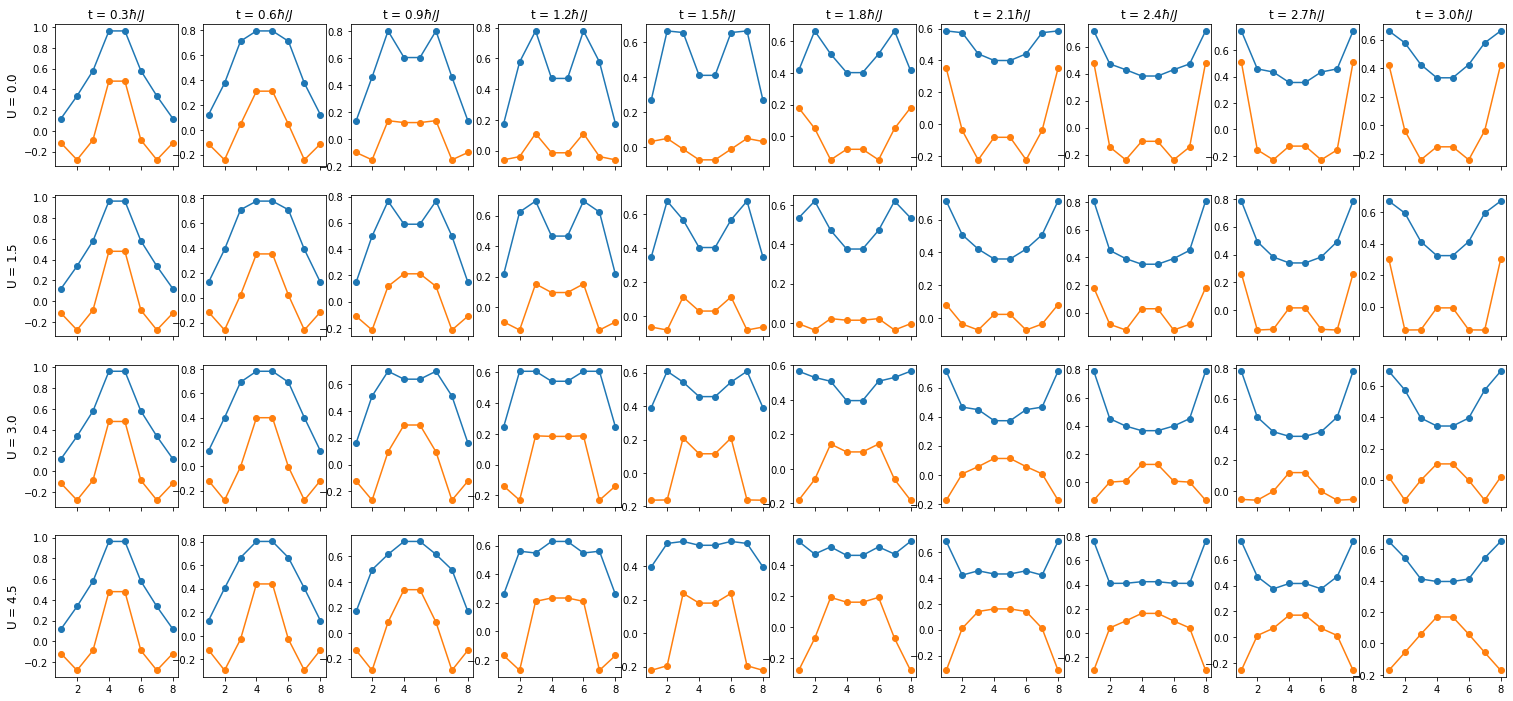

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import scipy
from scipy import sparse

#contructing number operator
nops = []
for ii in range(N_qubits):   #2*N to do it for all qubits
  diag = [0] * 2**(N_qubits-ii-1) + [1] * 2**(N_qubits-ii-1)
  diag = diag * 2**ii
  nops.append(diag)

times = np.arange(0.3, 3.3, 0.3)

U_vec = [0, 1.5, 3, 4.5]

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(26, 12), sharex=True)

for (ii, U) in enumerate(U_vec):

  H_J = [op + of.hermitian_conjugated(op) for op in (
         FermionOperator(((jj,1), (jj+2,0)), coefficient = -J) 
         for jj in range(N_qubits - 2))]
  hop =  sum(H_J)
  
  if(U!=0):
    H_U = [op for op in (
           FermionOperator(((jj,1), (jj,0), (jj+1, 1), (jj+1,0)), coefficient = U  )
           for jj in range(0, N_qubits, 2))]
    coulomb = sum(H_U)
  
  dt = 0.3
  trotter_steps = 10

  wave = initial
  real_times=[]
  charge_spread=[]
  spin_spread=[]
  t = 0

  for step in range(trotter_steps):

    wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(hop) * dt, wave)
    
    if (U!=0):
      wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(coulomb) * dt, wave)
    
    real_times.append(t)
    t += dt
    
    charge = []
    spin = []

    for i in range(N):
      nup = (np.conj(wave) * wave ) @ nops[2*i]
      ndown = (np.conj(wave) * wave ) @ nops[2*i + 1]

      charge.append(nup + ndown)
      spin.append(nup - ndown)

    axes[ii][step].plot(sites, charge, '-o');
    axes[ii][step].plot(sites, spin, '-o');

    assert np.isclose(sum(charge), 4)


    assert np.isclose(sum(spin), 0)
    

for (ii, ax) in enumerate(axes[0]):
    ax.set_title(rf"t = ${times[ii]:.1f}$" +r'$\hbar/J$')

for (jj, ax) in enumerate(axes[:,0]):
    ax.set_ylabel(rf"U = ${U_vec[jj]:.1f}$", size='large')

##Charge and spin spread

Here we compute and plot charge and spin densities spread $κ ^\pm _ η $ and its derivaty $\frac{dκ ^\pm }{dt}$ as functions of time for several interaction strengths U, where 

$κ ^\pm _ η = ∑_{j=1}^{N} | j - \frac{N+1}{2}| \rho^\pm_{j,η} $

and our sum will go from 0 to $N-1$, with $j \to j+1$, because of python numbering.


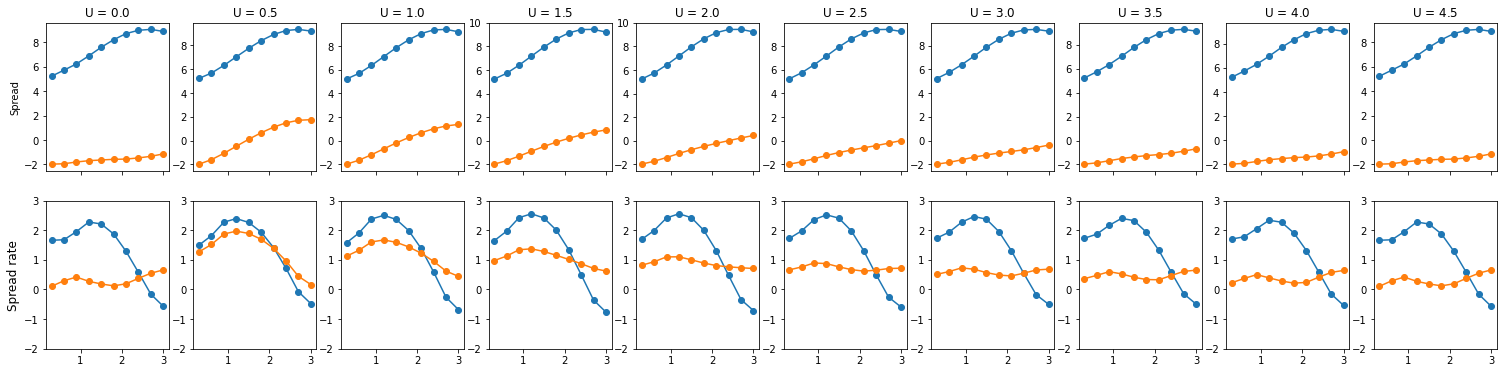

In [ ]:
def spread(vec, N):

  spreading = 0
  for ii in range(N):
    spreading += abs((ii+1) - (N+1)/2) * vec[ii]
  
  return spreading

#TROTTER
#hamiltonian of the systems which will evolve
U_vec = np.arange(0,5,0.5)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(26, 6), sharex=True)

for (ii, U) in enumerate(U_vec):
  if(U!=0):
    H_U = [op  for op in (FermionOperator(((i,1), (i,0), (i+1, 1), (i+1,0)), coefficient = U  )
               for i in range(0, N_qubits, 2))]
    coulomb = sum(H_U)

  dt = 0.3
  trotter_steps = 10
  wave = initial
  t = 0
  
  charge_spread = []
  spin_spread = []
  times = []

  for step in range(trotter_steps):

    wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(hop) * dt, wave)
    wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(coulomb) * dt, wave)

    t += dt
    
    charge = []
    spin = []
    
    for jj in range(N):
      nup = (np.conj(wave) * wave ) @ nops[2*jj]
      ndown = (np.conj(wave) * wave ) @ nops[2*jj + 1]

      charge.append(nup + ndown)
      spin.append(nup - ndown)

    times.append(t)
    charge_spread.append(spread(charge, N))
    spin_spread.append(spread(spin, N))

  axes[0][ii].plot(times, charge_spread, '-o');
  axes[0][ii].plot(times, spin_spread, '-o');
  axes[1][ii].plot(times, np.gradient(charge_spread, dt), '-o');
  axes[1][ii].plot(times, np.gradient(spin_spread, dt), '-o');
  axes[1][ii].set_ylim(-2, 3)

axes[:,0][0].set_ylabel("Spread")
axes[:,0][1].set_ylabel(r"Spread rate", size='large')

for (kk, ax) in enumerate(axes[0]):
    ax.set_title(rf"U = ${U_vec[kk]:.1f}$")

plt.show()

##Trotter Steps as a Quantum Circuit

In [ ]:
from openfermion.circuits import trotter

#definition complete Hubbard Hamiltonian used tu build the circuit
U=1
H_U = [op for op in (FermionOperator(((jj,1), (jj,0), (jj+1, 1), (jj+1,0)), coefficient = U)
           for jj in range(0, N_qubits, 2))]
hubbard_ham = sum(H_J) + sum(H_U)

#qubits
qubits = cirq.LineQubit.range(N_qubits)

# Compile the low rank Trotter step (only available algorithm for non diagonal matrices) using OpenFermion.
#hamiltonian has to be Interaction Operator or DiagonalCoulomb type
circuit = cirq.Circuit(
            trotter.simulate_trotter(
            qubits, of.transforms.get_interaction_operator(hubbard_ham),
            time=0.3, n_steps=1,
            algorithm=trotter.LOW_RANK))

# Use Cirq simulator to apply circuit.
simulator = cirq.Simulator()
result = simulator.simulate(circuit, qubit_order=qubits, initial_state=initial)
simulated_state = result.final_state_vector

# Print circuit.
cirq.DropNegligible().optimize_circuit(circuit)
print(circuit.to_text_diagram(transpose=False))

0: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhISwap(0.25)──────────Rz(0.179π)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Same procedure for $N↓=N\uparrow=3$

Sector N = 6 : S_z = 0
a'00000111'b'00000111' (1+0j)


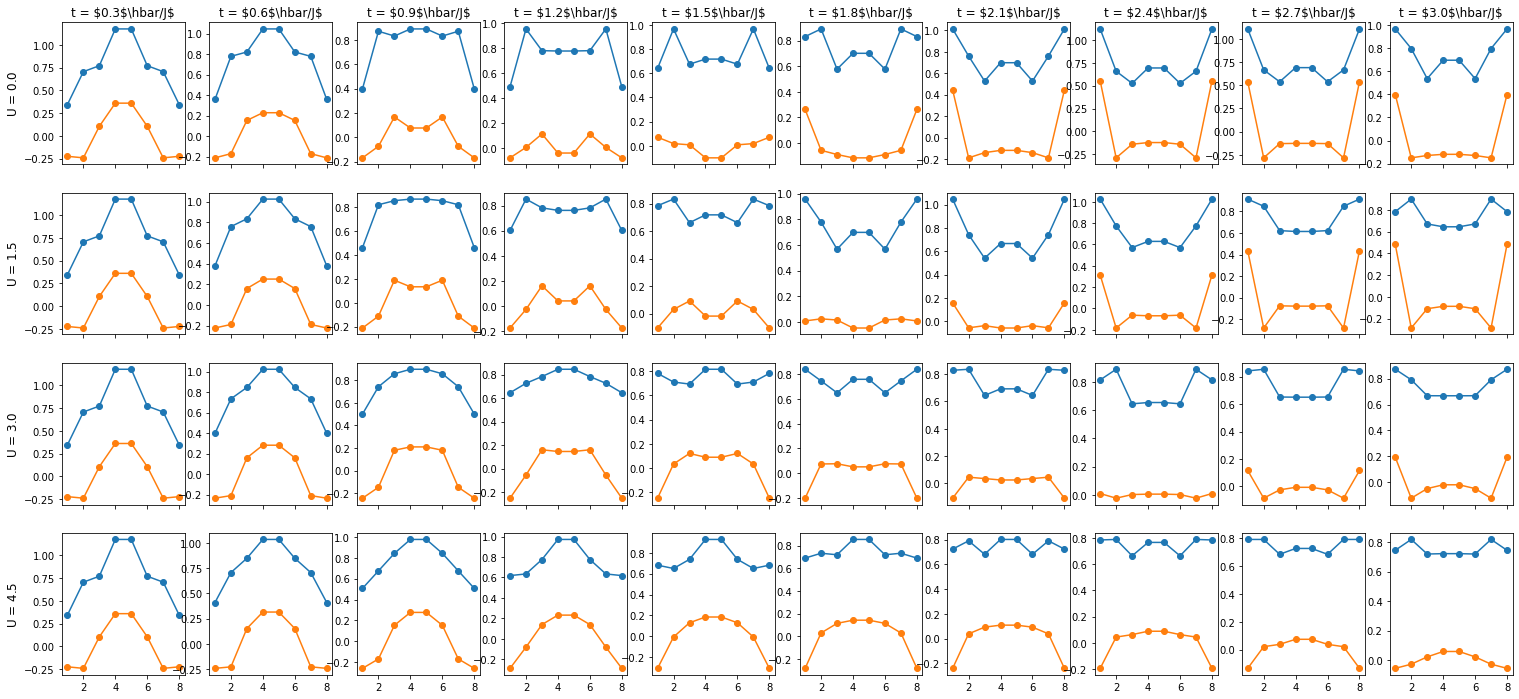

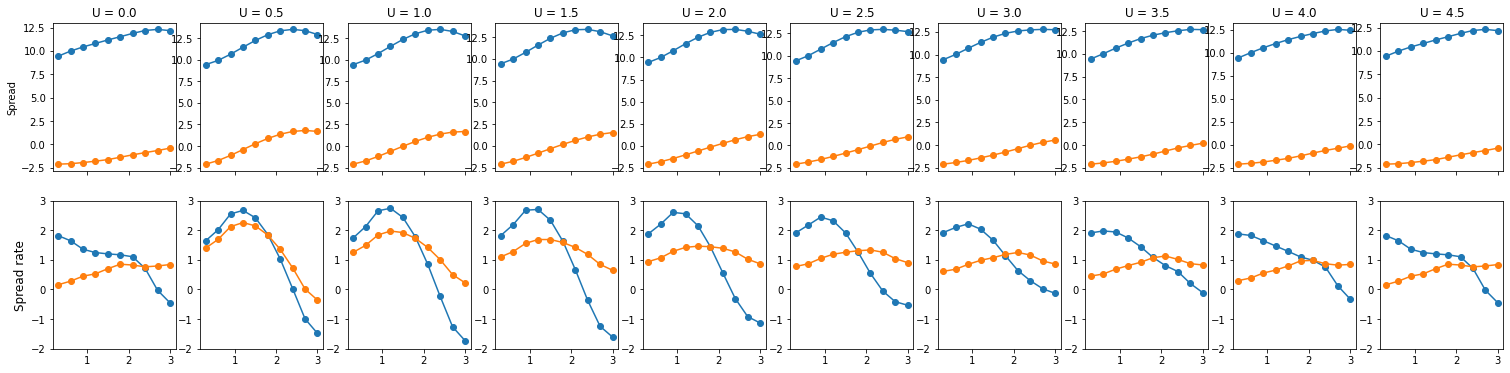

In [ ]:
N = 8
N_qubits = 2*N

#Preparing Operators for FQE
#------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------Hopping term-------------
J = 1.
hopping_fqe = np.diag([-J]*(N-1), k = 1) + np.diag([-J]*(N-1), k = -1)   #k is offset from diagonal

#------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------Interaction potential---------------------------------------------------------------
L = 4
m = 4.5
sigma = 1

#do it only for the up qubits
sites = np.arange(1, N+1)
potential_fqe = np.diag([-L * np.exp( -0.5 * (site-m)**2 / sigma**2  ) 
                         for site in sites])


init_wave = fqe.Wavefunction([[6, 0, N]])
init_wave.set_wfn(strategy = 'hartree-fock')
init_wave.print_wfn() 

ham_down = hopping_fqe
ham_up = ham_down + potential_fqe

_, eig_up = np.linalg.eigh(ham_up)
_, eig_down = np.linalg.eigh(ham_down)

init_wave = evolve_fqe_givens_sector(init_wave, eig_up, sector='alpha')
init_wave = evolve_fqe_givens_sector(init_wave, eig_down, sector='beta')

#check normalization
assert np.isclose(np.linalg.norm(fqe.to_cirq(init_wave)), 1)

#---------------------------------------------------------------------------------------------------------------------------
#to cirq; apparatus to express operators
initial = fqe.to_cirq(init_wave)


import warnings
warnings.filterwarnings('ignore')
import scipy
from scipy import sparse

#contructing spin density operator
nops = []
for ii in range(N_qubits):   #2*N to do it for all qubits
  diag = [0] * 2**(N_qubits-ii-1) + [1] * 2**(N_qubits-ii-1)
  diag = diag * 2**ii
  nops.append(diag)

times = np.arange(0.3, 3.3, 0.3)

U_vec = [0, 1.5, 3, 4.5]

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(26, 12), sharex=True)

for (ii, U) in enumerate(U_vec):

  H_J = [op + of.hermitian_conjugated(op) for op in (
         FermionOperator(((jj,1), (jj+2,0)), coefficient = -J) 
         for jj in range(N_qubits - 2))]
  hop =  sum(H_J)
  
  if(U!=0):
    H_U = [op for op in (
           FermionOperator(((jj,1), (jj,0), (jj+1, 1), (jj+1,0)), coefficient = U  )
           for jj in range(0, N_qubits, 2))]
    coulomb = sum(H_U)
  
  dt = 0.3
  trotter_steps = 10

  wave = initial
  real_times=[]
  charge_spread=[]
  spin_spread=[]
  t = 0

  for step in range(trotter_steps):

    wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(hop) * dt, wave)
    
    if (U !=0):
      wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(coulomb) * dt, wave)
    
    real_times.append(t)
    t += dt
    
    charge = []
    spin = []

    for i in range(N):
      nup = (np.conj(wave) * wave ) @ nops[2*i]
      ndown = (np.conj(wave) * wave ) @ nops[2*i + 1]

      charge.append(nup + ndown)
      spin.append(nup - ndown)

    axes[ii][step].plot(sites, charge, '-o');
    axes[ii][step].plot(sites, spin, '-o');

    assert np.isclose(sum(charge), 6)

    
    assert np.isclose(sum(spin), 0)

for (ii, ax) in enumerate(axes[0]):
    ax.set_title(rf"t = ${times[ii]:.1f}" +r'$\hbar/J$')

for (jj, ax) in enumerate(axes[:,0]):
    ax.set_ylabel(rf"U = ${U_vec[jj]:.1f}$", size='large')


def spread(vec, N):
  """
  Calculate the spread of spin and charge, given a vector with their values for all N sites.
  Need ii+1 for the site index because numbering starts from 0 in python
  """
  spreading = 0
  for ii in range(N):
    spreading += abs((ii+1) - (N+1)/2) * vec[ii]
  
  return spreading

#TROTTER
#hamiltonian of the systems which will evolve
U_vec = np.arange(0,5,0.5)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(26, 6), sharex=True)

for (ii, U) in enumerate(U_vec):
  if(U!=0):
    H_U = [op  for op in (FermionOperator(((i,1), (i,0), (i+1, 1), (i+1,0)), coefficient = U  )
               for i in range(0, N_qubits, 2))]
    coulomb = sum(H_U)

  dt = 0.3
  trotter_steps = 10
  wave = initial
  t = 0
  
  charge_spread = []
  spin_spread = []
  times = []

  for step in range(trotter_steps):

    wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(hop) * dt, wave)
    wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(coulomb) * dt, wave)

    t += dt
    
    charge = []
    spin = []
    for jj in range(N):
      nup = (np.conj(wave) * wave) @ nops[2*jj]
      ndown = (np.conj(wave) * wave) @ nops[2*jj + 1]

      charge.append(nup + ndown)
      spin.append(nup - ndown)

    times.append(t)
    charge_spread.append(spread(charge, N))
    spin_spread.append(spread(spin, N))

  axes[0][ii].plot(times, charge_spread, '-o');
  axes[0][ii].plot(times, spin_spread, '-o');
  axes[1][ii].plot(times, np.gradient(charge_spread, dt), '-o');
  axes[1][ii].plot(times, np.gradient(spin_spread, dt), '-o');
  axes[1][ii].set_ylim(-2, 3)

axes[:,0][0].set_ylabel("Spread")
axes[:,0][1].set_ylabel(r"Spread rate", size='large')

for (kk, ax) in enumerate(axes[0]):
    ax.set_title(rf"U = ${U_vec[kk]:.1f}$")

## Efficiency analysis 
Execution time is computed for different N. Code is performed for one trotter step and the case with $Q = 2, S_z = 0$.

In [ ]:
import time

tt=[]

times = np.arange(0.3, 3.3, 0.3)

U_vec = [0, 1.5, 3, 4.5]
dt = 0.3
trotter_steps = 1

for N in range(2, 12):
  start = time.time()
  N_qubits = 2*N
  #contructing number operator
  nops = []
  for ii in range(N_qubits):   #2*N to do it for all qubits
    diag = [0] * 2**(N_qubits-ii-1) + [1] * 2**(N_qubits-ii-1)
    diag = diag * 2**ii
    nops.append(diag)
    
    #----------------------------------------------Hopping term--------------------------------------------------------------------------------------------
  J = 1.
  hopping_fqe = np.diag([-J]*(N-1), k = 1) + np.diag([-J]*(N-1), k = -1)   #k is offset from diagonal

  #-----------------------------------------Interaction potential---------------------------------------------------------------

  #do it only for the up qubits
  sites = np.arange(1, N+1)
  potential_fqe = np.diag([-L * np.exp(-0.5 * (site - m)**2 / sigma**2)
                        for site in sites])
  
  init_wave = fqe.Wavefunction([[2, 0, N]])
  init_wave.set_wfn(strategy = 'hartree-fock')

  ham_down = hopping_fqe
  ham_up = ham_down + potential_fqe

  _, eig_up = np.linalg.eigh(ham_up)
  _, eig_down = np.linalg.eigh(ham_down)

  init_wave = evolve_fqe_givens_sector(
      init_wave, eig_up, sector='alpha')
  init_wave = evolve_fqe_givens_sector(
      init_wave, eig_down, sector='beta')              

  #---------------------------------------------------------------------------------------------------------------------------
  #to cirq; apparatus to express operators
  initial = fqe.to_cirq(init_wave)

  for (ii, U) in enumerate(U_vec):

    H_J = [op + of.hermitian_conjugated(op) for op in (
          FermionOperator(((jj,1), (jj+2,0)), coefficient = -J) 
          for jj in range(N_qubits - 2))]
    hop =  sum(H_J)
    
    if(U!=0):
      H_U = [op for op in (
            FermionOperator(((jj,1), (jj,0), (jj+1, 1), (jj+1,0)), coefficient = U  )
            for jj in range(0, N_qubits, 2))]
      coulomb = sum(H_U)
    

    wave = initial
    real_times=[]
    charge_spread=[]
    spin_spread=[]
    t = 0

    for step in range(trotter_steps):

      wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(hop) * dt, wave)
      
      if (U!=0):
        wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(coulomb) * dt, wave)
      
      real_times.append(t)
      t += dt
      
      charge = []
      spin = []

      for i in range(N):
        nup = (np.conj(wave) * wave) @ nops[2*i]
        ndown = (np.conj(wave) * wave) @ nops[2*i + 1]

  end = time.time()
  tt.append(end-start)


In [ ]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

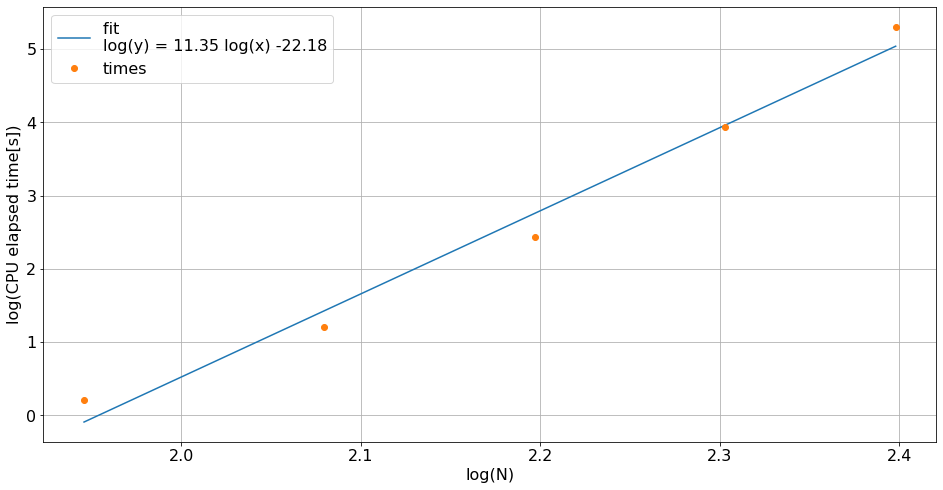

In [ ]:
log_x = np.log(range(7,12)) 
log_y = np.log(tt[5:])


b_us, c_us = np.polyfit(log_x, log_y, 1)

fit = np.poly1d((b_us, c_us)) 

fig, ax = plt.subplots(figsize = (16,8))

ax.plot(log_x, fit(log_x), 
        label = 'fit \n'+ 'log(y) = '+str(format(b_us, '.2f'))+' log(x) '+str(format(c_us, '.2f')))
ax.plot(log_x, log_y, 'o', label ='times')

ax.set(xlabel = 'log(N)', ylabel = 'log(CPU elapsed time[s])')
ax.legend()
ax.grid(True)